## Nonlinear pulse propagation

Will use parameters from Marc's paper[1] to validate code.

[1] Temporal Simultons in Optical Parametric Oscillators, PRL, 2018

In [1]:
import nonlinear #This is my library
from util import sech

import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
import time
import scipy
from matplotlib import cm

from scipy.constants import pi, c

In [2]:
#Change size of plots
plt.rcParams['figure.figsize'] = [14, 5]

## Units
We'll work in the following units:

time = fs <br>
frequency = PHz (1/time) <br>
distance = mm

In [3]:
c = c*1e-12; #mm/fs, [Freq]=PHz

## Time and Frequency domain windows

In [4]:
NFFT = 2**10 #Fourier size

Tmax = 2000 #(fs) (window will go from -Tmax to Tmax)
t = np.linspace(-Tmax, Tmax, NFFT, endpoint=False)
ts = t[1]-t[0] #Sampling period

print('Sampling Rate =', ts, 'fs')

Sampling Rate = 3.90625 fs


## Signal pulse creation

4.124e-17 fJ
4.124e-17 fJ


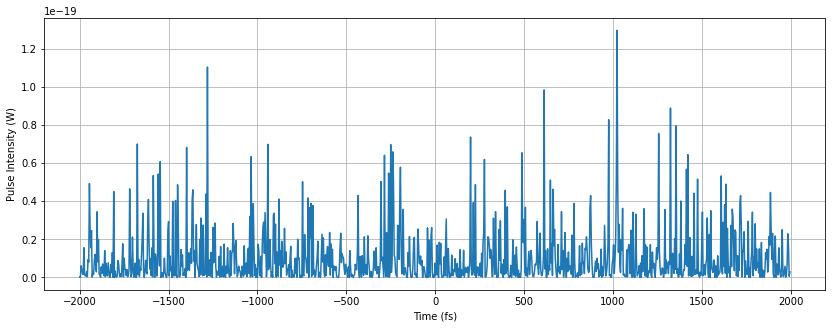

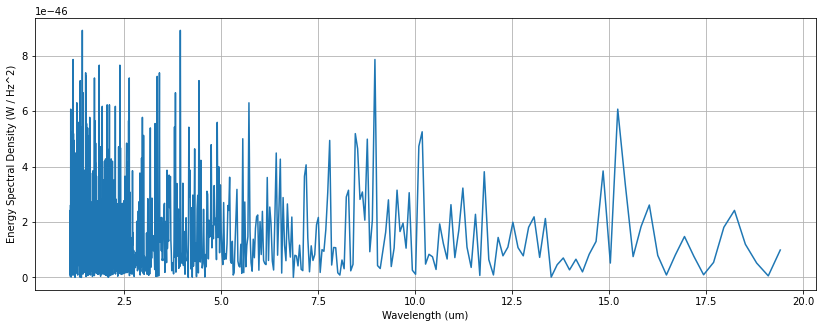

In [5]:
wla = 2.090e-3 #signal wavelength (mm)
noise = 1e-10*np.random.normal(size=NFFT)
# noise = 1e-10*np.ones(NFFT)
signal = nonlinear.pulse(t, noise, wla*1e3)

signal.plot_magsq_vs_time()
signal.plot_ESD_vs_wavelength()
print(format(signal.energy_td()*1e15, '0.3e'), 'fJ')
print(format(signal.energy_fd()*1e15, '0.3e'), 'fJ')

## Pump pulse creation

2.000e+00 nJ
2.000e+00 nJ


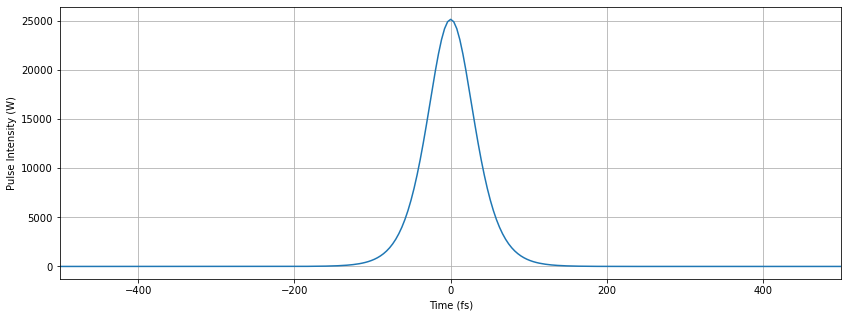

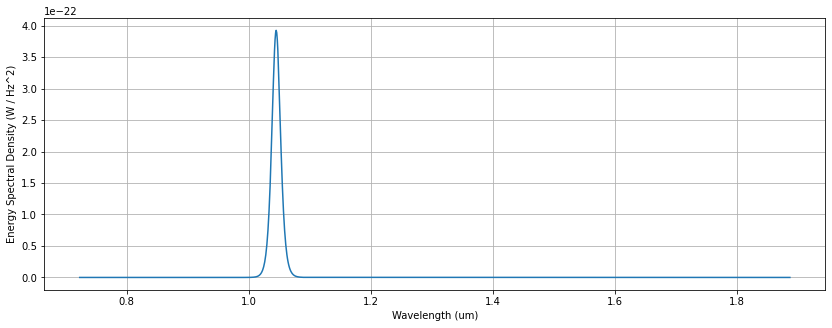

In [6]:
#Parameters
wlb = wla/2 #pump wavelength (mm)
pump_pwr = 0.5 #Average pump power (W)
Tp = 70 #Input pulse width (fs)

#Pulse creation
tau = Tp/1.76
pulse = np.sqrt(0.88*4e6/Tp*pump_pwr)*sech(t/tau)
pump = nonlinear.pulse(t, pulse, wlb*1e3)

pump.plot_magsq_vs_time(xlim=[-500,500])
pump.plot_ESD_vs_wavelength()
print(format(pump.energy_td()*1e9, '0.3e'), 'nJ')
print(format(pump.energy_fd()*1e9, '0.3e'), 'nJ')

## Input parameters

In [7]:
#The pulse includes a natural FFT frequency axis
Omega = pump.omega*1e-3
print('Freq resolution =', Omega[1]*1e3/(2*pi), 'THz')

#OPO parameters
wa = 2*pi*c/wla #Central angular frequency for pulse "a"
Co_loss = 1-0.65  #Output coupler loss
dT = 4 #Detuning in fs
l = c*dT/wlb #Detuning parameter l
Ws = 14e-3 #Beam waist of signal (mm)
Nrt = 200 #Round trips

Freq resolution = 0.25 THz


## Feedback Loop

In [8]:
#Cavity dispersion parameters
phi2 = 25*2
phi3 = 76
phi4 = -13020
# phi5 = 983328
phi5 = 0

#Feedback loop
deltaphi = (phi2/2)*Omega**2 + (phi3/6)*Omega**3 + (phi4/24)*Omega**4 + (phi5/120)*Omega**5
phi = pi*l + dT*Omega + deltaphi
fb = np.sqrt(Co_loss)*np.exp(1j*phi)

#Linear element representing this feedback path
fb = nonlinear.linear_element(fb)

## Nonlinear element

In [9]:
#Crystal dispersion
alpha_a = 0.00691 #loss for signal in crystal (1/mm)
alpha_b = 0.00691 #loss for pump in crystal (1/mm)
u = 112.778 #Group velocity mismatch (fs/mm)
b2a = -53.64 #second order GVD signal (fs^2/mm)
b3a = 756.14 #third order GVD signal (fs^3/mm)
b4a = -2924.19 #fourth order GVD signal (fs^4/mm)
b2b = 240.92 #second order GVD pump (fs^2/mm)
b3b = 211.285 #second order GVD pump (fs^3/mm)
b4b = -18.3758 #second order GVD pump (fs^4/mm)
deff = 2/pi*16e-9 #effective nonlinear coefficient (mm/V)
na = 2.2333# refractive index at signal
nb = 2.1935# refractive index at pump

#Dispersion functions
Da = alpha_a/2 - 1j*b2a*Omega**2/2 - 1j*b3a*Omega**3/6 - 1j*b4a*Omega**4/24
Db = alpha_b/2 - 1j*u*Omega - 1j*b2b*Omega**2/2 - 1j*b3b*Omega**3/6 - 1j*b4b*Omega**4/24

#Crystal parameters
L = 1 #mm
h = L/50 #Distance step Size

#Nonlinear coupling
nlc = np.sqrt(2*377)*deff*(Omega+wa)/(Ws*na*c*np.sqrt(pi*nb))

crystal = nonlinear.nonlinear_element(L=L, h=h, Da=Da, Db=Db, nlc=nlc)

## OPO Function

In [10]:
def opo(signal, pump, nl_element, feedback):

    #Roundtrip numbers, to be optimized for convergence
    N = 200
    
    #Variables to save roundtrip evolution
    signal_evolution = np.zeros([N, pump.NFFT])
    signal_energy_evol = np.zeros(N)
    pump_energy_evol = np.zeros(N)
    
    for kn in range(N):
        [signal, pump_out] =  crystal.propagate(signal, pump)
            
        #Apply feedback
        fb.propagate(signal)
        
        signal_evolution[kn,:] = (np.abs(signal.e)/np.max(np.abs(signal.e)))**2
        signal_energy_evol = signal.energy_td()
        pump_energy_evol = pump_out.energy_td()
        
        if (kn+1)%50==0:
            print('Completed roundtrip ' + str(kn+1))
    
    return signal, pump_out, signal_evolution, signal_energy_evol, pump_energy_evol

## OPO Test

In [11]:
tic = time.time();
signal, pump_out, signal_evolution, signal_energy_evol, pump_energy_evol = opo(signal, pump, crystal, fb);
elapsed = time.time() - tic;
print('Time elapsed = ' + str(round(elapsed,5)) + ' seconds')

Completed roundtrip 50
Completed roundtrip 100
Completed roundtrip 150
Completed roundtrip 200
Time elapsed = 4.67717 seconds


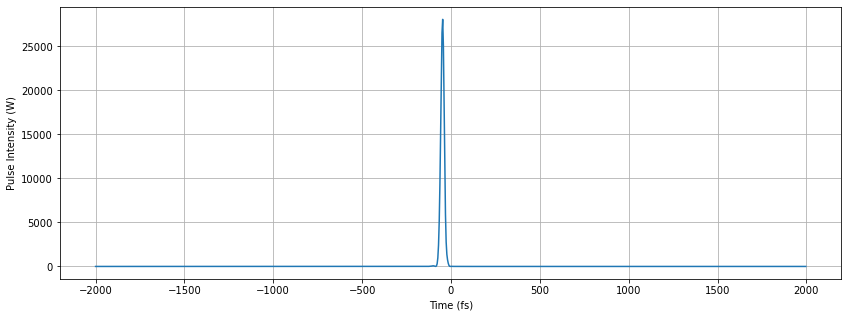

In [12]:
signal.plot_magsq_vs_time()

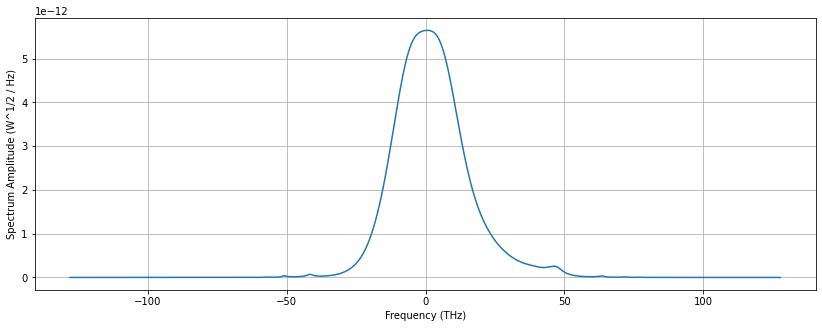

In [13]:
signal.plot_spectrum()

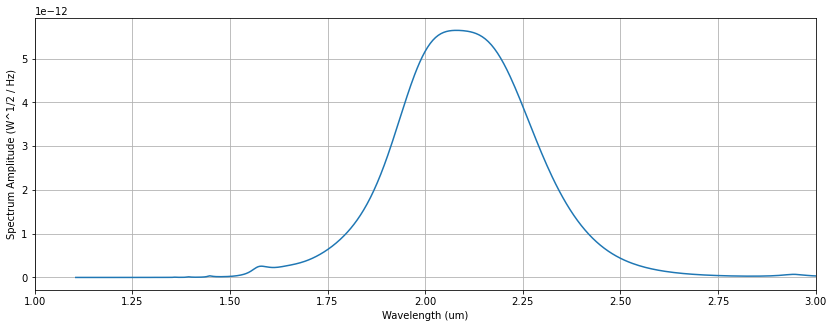

In [23]:
signal.plot_spectrum_vs_wavelength(xlim=[1,3])

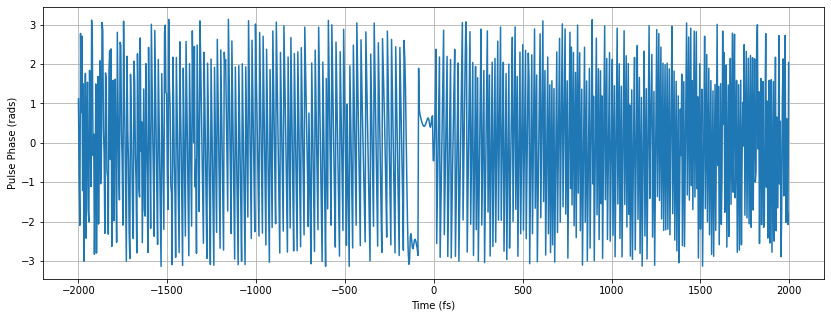

In [24]:
signal.plot_phase_vs_time()

In [15]:
# B = fftshift(fft(b_out))
# fig = plt.figure()
# ax1 = fig.add_subplot(121)
# ax2 = fig.add_subplot(122)
# ax1.plot(t,np.abs(b_out)**2);
# ax2.plot(fftshift(Omega), 20*np.log10(abs(B)/np.amax(abs(B))))
# ax2.set_xlim(-1,1);
# ax1.set_title('b vs time');
# ax2.set_title('B vs freq');

# A = fftshift(fft(a_out))
# fig = plt.figure()
# ax1 = fig.add_subplot(121)
# ax2 = fig.add_subplot(122)
# ax1.plot(t,np.abs(a_out)**2);
# ax2.plot(fftshift(Omega), 20*np.log10(abs(A)/np.amax(abs(A))))
# #ax2.set_xlim(-1,1);
# ax1.set_title('a vs time');
# ax2.set_title('A vs freq');

# f = c/wla + fftshift(Omega)/2/pi
# wl = c/f
# fig = plt.figure()
# ax1 = fig.add_subplot(121)
# ax2 = fig.add_subplot(122)
# ax1.plot(wl*1e3, 20*np.log10(abs(B)/np.amax(abs(B))))
# ax1.set_xlim([1,2])
# ax1.set_ylim([-30,0])

# ax2.plot(wl*1e3, 20*np.log10(abs(A)/np.amax(abs(A))))
# ax2.set_xlim([1.5,3])
# ax2.set_ylim([-30,0])

In [16]:
# #plt.imshow(np.transpose(evol))
# X,Y = np.meshgrid(np.arange(1,Nrt+1), t)
# # Y.shape
# plt.contourf(X, Y, np.transpose(evol), 100)
# plt.ylim([-200,200])
# plt.xlim([0,100])

In [17]:
# plt.contourf(X, Y, np.transpose(evol), 100)
# plt.ylim([-200,200])

## Sweep Detuning